In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from pyESN import ESN

In [2]:
# Read time series for McDonald's stock and drop non open/high/low/close/volume columns
mcd = pd.read_csv('EOD-MCD.csv', index_col=0)
mcd.drop(['Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume','Dividend','Split'], axis=1, inplace=True, errors="skip")
mcd.sort_index(inplace=True)
mcd.head()

,Open,High,Low,Close,Volume
Date,,,,,
1970-01-02,43.00,44.25,43.0,44.25,23256.0
1970-01-05,44.25,45.00,44.0,45.00,18193.0
1970-01-06,45.00,45.75,45.0,45.25,16059.0
1970-01-07,45.25,45.75,45.0,45.00,22459.0
1970-01-08,45.00,45.38,45.0,45.00,18456.0


In [3]:
# Get Features and predicting variable, which is chosen to be Adj_Close since it determines the price of a stock at the end of a day
X = mcd.drop(['Close'], axis=1).values
Y = mcd['Close'].values

# Split data into 75/25 train/test
train_len = floor(X.shape[0]*0.75)
train_x = X[:train_len]
train_y = Y[:train_len]
test_x = X[train_len:]
test_y = Y[train_len:]

assert(train_x.shape[0] + test_x.shape[0] == X.shape[0])

# Reshape Y so that ESN work
train_y = np.reshape(train_y,newshape=(train_y.shape[0],1))
test_y = np.reshape(test_y,newshape=(test_y.shape[0],1))

In [4]:
def nrmse(y, yhat):
    """
        Function to output Normalized Mean Square Error of two numpy arrays
    """
    y = np.reshape(y, -1)
    yhat = np.reshape(yhat, -1)
    error = np.sqrt(np.mean((y-yhat)**2))/(np.max(y) - np.min(y))
    return error

## Task 1: Impact of input and RNN weight scalings on performance of ESN

In order to solve Task 1, i.e. check how performance is affected by scaling input weights $W_{ax}$ and RNN weights $W_{aa}$, we need to generate various scalings for each of four inputs and run train/test for this specific model.

In [5]:
def cartprod(*arrays):
    N = len(arrays)
    return np.transpose(np.meshgrid(*arrays, indexing='ij'), np.roll(np.arange(N + 1), -1)).reshape(-1, N)

In [6]:
# Generate scalings for each of four inputs
scalings = []
for i in range(4):
    scalings.append(np.arange(0.5, 5, step = 0.5))

input_scalings = cartprod(*scalings)
input_scalings.shape

(6561, 4)

In [ ]:
# For each combination of input scalings run training and testing on McDonald's stock data and record the results.
input_scaling_nrmse = []
input_scaling_labels = []
for i in range(input_scalings.shape[0]):
    esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95,
          input_scaling = input_scalings[i])
    
    esn.fit(train_x, train_y)
    predictions = esn.predict(test_x)
    error = nrmse(test_y, predictions)
    label = f"{input_scalings[i][0]}-{input_scalings[i][1]}-{input_scalings[i][2]}-{input_scalings[i][3]}"
    print(f"Iteration: {i}, label: {label}, NRMSE: {error}")
    input_scaling_nrmse.append(error)
    input_scaling_labels.append(label)

df = pd.DataFrame({'label': input_scaling_labels, 'nrmse': input_scaling_nrmse})
df.to_csv('input_scaling_results.csv',index=False)

After running the training and testing for each input scaling, we can compare it with performance of ESN without providing input scalings and plot how error rate is changing for specific scaling. The result is saved in 'input_sacling_results.csv' file, which contains 2 columns: 'label' and 'nrmse', where label is 4 numbers that are used in scaling 4 inputs, separated by dash.

In [7]:
scalings_results = pd.read_csv('input_scaling_results.csv')
scalings_results.head()

,label,nrmse
0,0.5-0.5-0.5-0.5,0.002889
1,0.5-0.5-0.5-1.0,0.002888
2,0.5-0.5-0.5-1.5,0.002895
3,0.5-0.5-0.5-2.0,0.002893
4,0.5-0.5-0.5-2.5,0.002891


In [8]:
# Let's train/test ESN without providing any input scaling so that we can compare with the rest.
esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95)
esn.fit(train_x, train_y)
predictions = esn.predict(test_x)
no_scaling_error = nrmse(test_y, predictions)
print(f"No scaling NRMSE is: {no_scaling_error}")

No scaling NRMSE is: 0.002884034183843359


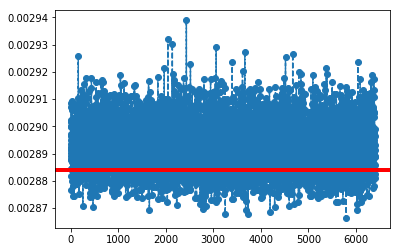

In [9]:
scaling_nrmses = scalings_results['nrmse'].values
scaling_labels = scalings_results['label'].values

fig, ax = plt.subplots()
ax.plot(scaling_nrmses, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()

Above given plot shows the NRMSE for various input scalings, while red line shows the error of ESN without scaling any input. Since the graph is not showing very well how error was improved due to big amount of points, we should plot only those errors that are below the red line.

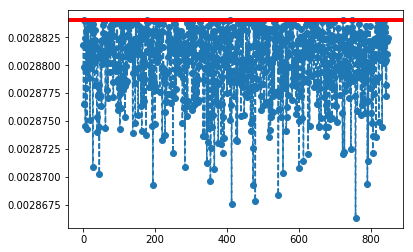

No scaling error is: 0.002884034183843359 and lowest with scaling error is: 0.002866340332593146

The error is improved by: 0.6172976407936126%

The best scaling for 4 inputs is: 4.0-4.5-3.0-0.5



In [10]:
better_errors = scaling_nrmses[np.where(scaling_nrmses < no_scaling_error)[0]]

fig, ax = plt.subplots()
ax.plot(better_errors, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()
percentage_improvement = 100*(no_scaling_error/np.min(scaling_nrmses) - 1)
best_scaling = scaling_labels[np.argmin(scaling_nrmses)]

print(f"No scaling error is: {no_scaling_error} and lowest with scaling error is: {np.min(scaling_nrmses)}\n")
print(f"The error is improved by: {percentage_improvement}%\n")
print(f"The best scaling for 4 inputs is: {best_scaling}\n")

As we can see the input scalings indeed improve the test error, aka performance compared to no scaling of inputs. However the improvement in error rate is just 0.77%, which is not a lot. The error itself is quite low, so improving farther is obviously hard.

## Task 2: Impact of Teacher Signal scaling and shifting on performance of ESN

Since we saw what was the impact on performance from scaling of inputs, we can proceed and check the impact on scaling and shifting of teacher signal. First we need to generate 2 arrays and perform cartesian product to form all possible combinations of scaling and shifting teacher signal parameters.

In [11]:
teach_scaling = np.arange(0.1, 5, step=0.1)
teach_shift = np.arange(-5, 5, step=0.1)

teacher_scalings = cartprod(teach_scaling, teach_shift)

In [ ]:
# For each combination of teaching scalings run training and testing on McDonald's stock data and record the results.
teacher_scaling_nrmse = []
teacher_scaling_labels = []
for i in range(teacher_scalings.shape[0]):
    esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95,
          teacher_scaling = teacher_scalings[i][0],
          teacher_shift = teacher_scalings[i][1])
    
    esn.fit(train_x, train_y)
    predictions = esn.predict(test_x)
    error = nrmse(test_y, predictions)
    label = f"{teacher_scalings[i][0]}-{teacher_scalings[i][1]}"
    print(f"Iteration: {i}, label: {label}, NRMSE: {error}")
    teacher_scaling_nrmse.append(error)
    teacher_scaling_labels.append(label)

df = pd.DataFrame({'label': teacher_scaling_labels, 'nrmse': teacher_scaling_nrmse})
df.to_csv('teacher_scaling_results.csv',index=False)

In [12]:
teacher_scaling_results = pd.read_csv('teacher_scaling_results.csv')
teacher_scaling_results.head()

,label,nrmse
0,0.1_-5.0,0.002872
1,0.1_-4.9,0.002885
2,0.1_-4.8,0.002877
3,0.1_-4.7,0.002877
4,0.1_-4.6,0.002875


After running training and testing for all combinations of teacher scaling and shifting, we can proceed to understand how they affect the overall performance in terms of testing error.

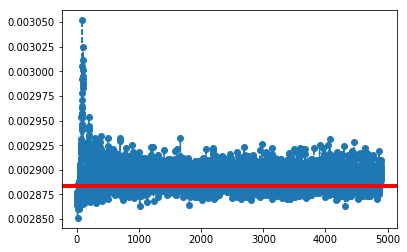

In [13]:
teacher_scaling_nrmses = teacher_scaling_results['nrmse'].values
teacher_scaling_labels = teacher_scaling_results['label'].values

fig, ax = plt.subplots()
ax.plot(teacher_scaling_nrmses, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()

As with input scalings we see that some values are below the no scaling error, so we need to again plot a graph where values are only less than error without scaling.

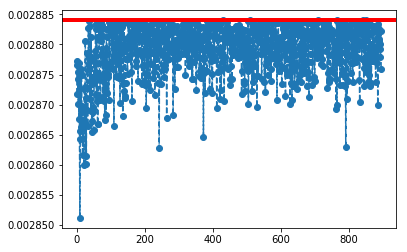

No scaling error is: 0.002884034183843359 and lowest with scaling error is: 0.002866340332593146

The error is improved by: 1.1529842956963465%

The best scaling for teacher and shiftings are: 0.1_-4.0 respectively



In [16]:
teacher_better_errors = teacher_scaling_nrmses[np.where(teacher_scaling_nrmses < no_scaling_error)[0]]

fig, ax = plt.subplots()
ax.plot(teacher_better_errors, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()
percentage_improvement = 100*(no_scaling_error/np.min(teacher_better_errors) - 1)
best_scaling = teacher_scaling_labels[np.argmin(teacher_scaling_nrmses)]

print(f"No scaling error is: {no_scaling_error} and lowest with scaling error is: {np.min(scaling_nrmses)}\n")
print(f"The error is improved by: {percentage_improvement}%\n")
print(f"The best scaling for teacher and shiftings are: {best_scaling} respectively\n")

Again as with scaling of inputs, the error wasn't improved much. It is mainly due to the fact that the initial error without any scaling was already very small.

## Task 3: Memory capacity of ESN Network